Learned H = 30 <br>
Length of sequence = 100 <br>
This note book uses a new target R



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.regularizers import l1_l2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Main driver functions

In [2]:
# Global Parameters:
H_learned = 30
seq_len = 100
regularizers_rate = 0.1
learning_rate = 0.001
EPOCHES = 6000

In [3]:
def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]
    # return tf.constant(.8, tf.float32)

def rexp():
    return -tf.math.log(runif())

def reloid(x):
  '(sigma(x[1]), ..., sigma(x[-2]), relu(x[-1])'
  return tf.concat([tf.nn.sigmoid(x[:-1]), tf.nn.relu(x[-1:])], axis=0)

# @tf.function
def reloid_derivative(x):
  return tf.concat([
    tf.nn.sigmoid(x[:-1]) * (1 - tf.nn.sigmoid(x[:-1])), # derivative of sigmoid
    tf.cast(x[-1:] > 0, x[-1:].dtype) # derivative of relu
  ], axis=0)

# @tf.function
def R(x, theta):
  '''
  x: scalar
  theta: (3, H)
  '''
  # theta = tf.convert_to_tensor(theta,dtype='float64')
  x = tf.convert_to_tensor(x,dtype='float64')
  # convert to vectors
  with tf.control_dependencies([
    tf.debugging.assert_positive(x, message="R: x>0")                              
  ]):
    w = tf.expand_dims(theta,-1)[0]
    v = tf.expand_dims(theta,-1)[1]
    b = tf.expand_dims(theta,-1)[-1] 

  exp_w_v = tf.math.exp([w, v])
  ew = exp_w_v[0]
  ev = exp_w_v[1]
  sigb = tf.math.sigmoid(b) # try this
  x = tf.reshape(x, (1, 1))

  r = tf.where(tf.math.less(x, 1e-4), 
           tf.transpose(ev) @ (ew * reloid_derivative(b)) * x, # first order Taylor expansion
           tf.transpose(ev) @ (reloid(ew @ x + b) - reloid(b)))
  return  r
  
# @tf.function
def Rinv(y, theta):
  y = tf.convert_to_tensor(y,dtype='float64')
  x_left = 0
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1]   
  # as x -> oo, R is asymyptotic to exp(v[-1] + w[-1]) x
  # fixme: calculate this exactly.
  x_right = 1e8
  # tf.print(y)
  # tf.print('y',y)
  # tf.print(R(x_right, theta))
  tf.debugging.assert_greater(R(x_right, theta), y, message="R(x_right)>y inv")
  for i in range(120):
    x_i = (x_left + x_right) / 2.
    y_i = R(x_i, theta)
    left = tf.cast(y_i < y, dtype='float64')
    x_left = left * x_i + (1. - left) * x_left
    x_right = (1. - left) * x_i + left * x_right
  return x_i

@tf.custom_gradient
def custom_Rinv(y, theta):
  y = tf.convert_to_tensor(y,dtype='float64')
  x = Rinv(y, theta)
  with tf.GradientTape() as g:
    g.watch([x, theta])
    y = R(x, theta)
  dR_dtheta, dR_dx = g.gradient(y, [theta, x])
  def grad(dx):
    return dx / dR_dx, -dx * dR_dtheta / dR_dx
  return x, grad

# custom_Rinv(tf.constant(5.), theta)

@tf.function
def gen_gaps(theta_vector, k: int, 
             theta=tf.constant(1e-4, dtype=tf.float64), 
             rho=tf.constant(1e-5, dtype=tf.float64)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    # w, v, b = tf.expand_dims(theta_vector,-1) # convert to vectors
    theta_vector = tf.cast(theta_vector,dtype='float64')
    w = tf.expand_dims(theta_vector,-1)[0]
    v = tf.expand_dims(theta_vector,-1)[1]
    b = tf.expand_dims(theta_vector,-1)[-1] 

    z = tf.convert_to_tensor([[rexp()]])
    x = custom_Rinv(z, theta_vector)[0]  # initialize x by sampling from prior
    tf.debugging.assert_positive(x, message='gen_gaps first x')

    pos = tf.constant([0.], dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 2)

    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = R(u_x,theta_vector) # compute R(u_x)
        x = custom_Rinv((z + r_u_x), theta_vector)[0]  # segment height
        # tf.print(x)
        # tf.print(z+r_u_x,"\n")
        with tf.control_dependencies(
            [tf.debugging.assert_all_finite(x,'second x'),
             tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          next_event = rexp() / (x * (theta + rho))
          tf.debugging.assert_positive(next_event, message='gen_gaps first gap')
          pos += next_event  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            next_event = rexp() / (x * (theta + rho))
            tf.debugging.assert_positive(next_event, message='gen_gaps second gap')
            pos += next_event  # length to next event

    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gaps have non-positive entry'
        ,summarize=100)
    ]):
      return diff

def R_learned(x):
  return R(x, generator.weights[0])

## real R

In [ ]:
def eta(x):
  x = tf.cast(x, 'float64')
  thresh = tf.constant([1e-1],dtype='float64', shape=(1,))
  one = tf.ones(shape=[1,], dtype='float64')
  return tf.cast(tf.where(x < thresh, thresh, one), 'float64')

def R_real(x):
  '''R_real(x) = integral_0^x eta(t) dt'''
  x = tf.cast(x, 'float64')
  thresh = tf.constant([1e-1],dtype='float64', shape=(1,))
  tf.debugging.assert_positive(x, message="R_real: x>0")  
  return tf.cast(tf.where(x < thresh, x * thresh, thresh**2 + (x - thresh)), 'float64')

def R_real_inv(y):
  y = tf.cast(y, 'float64')
  tf.debugging.assert_positive(y, message="R_real: x>0")  
  thresh = tf.constant([1e-1],dtype='float64', shape=(1,))
  return tf.cast(tf.where(y < thresh, y / thresh, y - (thresh**2 - thresh)), 'float64')

@tf.function
def gen_gaps_real(k: int, 
             theta=tf.constant(1e-4, dtype=tf.float64), 
             rho=tf.constant(1e-5, dtype=tf.float64)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    z = rexp()
    x = R_real_inv(z)  # initialize x by sampling from prior
    tf.debugging.assert_positive(x, message='gen_gaps first x')

    pos = tf.constant([0.], dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 2)

    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = u * x
        r_u_x = R_real(u_x) # compute R(u_x)
        x = R_real_inv(z + r_u_x) # segment height
        # print(x)
        with tf.control_dependencies(
            [tf.debugging.assert_all_finite(x,'second x'),
             tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          next_event = rexp() / (x * (theta + rho))
          tf.debugging.assert_positive(next_event, message='gen_gaps first gap')
          pos += next_event  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            next_event = rexp() / (x * (theta + rho))
            tf.debugging.assert_positive(next_event, message='gen_gaps second gap')
            pos += next_event  # length to next event

    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gaps have non-positive entry'
        ,summarize=100)
    ]):
      return diff


## Generator


In [5]:
class CustomGenGaps(keras.layers.Layer):
  ''' Take one parameter H as input 
      Then construct one hidden layer with H units'''
  def __init__(self, H, name='gen_gaps_layer'):
      super(CustomGenGaps, self,).__init__(name=name)
      init = tf.random_normal_initializer(stddev=2)
      self.theta = self.add_weight(shape=(3,H), initializer=init, dtype='float64',
                               trainable=True,
                              #  constraint=tf.keras.constraints.NonNeg(),
                               regularizer = l1_l2(regularizers_rate,regularizers_rate)
                              )

  def call(self,length):
      return tf.reshape(gen_gaps(self.theta,length),[1,length])

class Generator(keras.Model):
  ''' wrap the GenGaps layer into Keras Model '''
  def __init__(self, H):
    super(Generator, self).__init__()
    self.GenLayer = CustomGenGaps(H)

  def call(self, inputs, training=True):
    return self.GenLayer(inputs)

generator = Generator(H_learned)
generator(10)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[ 737256.44119387,  727483.99025441,  912859.87073179,
         260282.76423203,   26081.72959878, 1807978.34156181,
         372005.46459691,   11286.92262045,   53369.24869216,
         945009.23172819]])>

In [6]:
def SSE(x):
  ''' Calculate difference between real and learned function '''
  r_hat = R_learned(x)[0][0]
  r = R_real(x)
  x = tf.cast(x, 'float64')
  return tf.math.sqrt(tf.math.square(r_hat - r)) * tf.math.exp(-x) # make integral convergent

SSE(1.)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([21.83682258])>

Objective funtion

In [7]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Comparison between real and fake $R(x)$

In [8]:
# def integral(y, x):
#     '''Left Riemann sum'''
#     dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
#     return tf.reduce_sum(y[:-1]) * dx

# def integral(y, x):
#     '''Boole's Method'''
#     dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
#     return (14*(y[0] + y[-1]) + 64*tf.reduce_sum(y[1:-1:2]) + 24*tf.reduce_sum(y[2:-1:4]) + 28*tf.reduce_sum(y[4:-1:4])) * dx / 45

# def integral(y, x):
#     '''Simpson's Method'''
#     dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
#     return (y[0] + y[-1] + 4*tf.reduce_sum(y[1:-1:2]) + 2*tf.reduce_sum(y[2:-1:2])) * dx / 3

def integral(y, x):
    '''Trapezoidal Method'''
    y = tf.cast(y, 'float64')
    x = tf.cast(x, 'float64')
    dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
    return ((y[0] + y[-1])/2 + tf.reduce_sum(y[1:-1])) * dx

In [14]:
integral([SSE(i) for i in x_li],x_li)[0]

<tf.Tensor: shape=(), dtype=float64, numpy=21.600374912219>

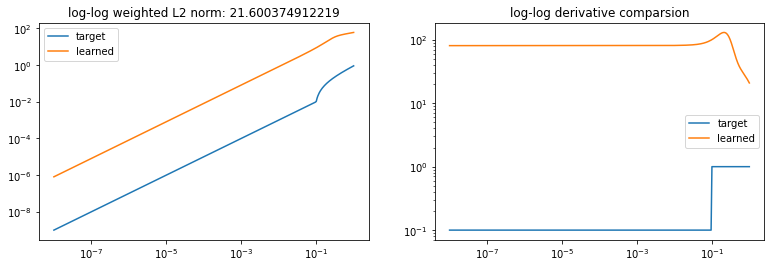

In [15]:
x_li = tf.linspace(1e-8, 1, num=200)
x_li = tf.cast(x_li, 'float64')

grad_real = [eta(i) for i in x_li]
y_real = [R_real(i) for i in x_li]

def performance_check(generator):
  plt.figure(figsize=(13,4))
  plt.subplot(121)
  # Real Generator Plot  
  plt.plot(tf.reshape(x_li,[-1]),tf.reshape(y_real,[-1]), label='target')
  # Plot fake R
  y = [R_learned(i) for i in x_li]
  plt.plot(tf.reshape(x_li,[-1]),tf.reshape(y,[-1]), label='learned')
  plt.yscale('log')
  plt.xscale('log')
  error = integral([SSE(i) for i in x_li],x_li)[0]
  plt.title(f'log-log weighted L2 norm: {error}') 
  plt.legend()

  plt.subplot(122)
  plt.plot(tf.reshape(x_li,[-1]),grad_real,label='target')

  grad=[]
  for x in x_li:
    with tf.GradientTape() as g:
      g.watch(x)
      y = R_learned(x)
    grad.append(g.gradient(y, x))

  plt.plot(tf.reshape(x_li,[-1]),grad,label='learned')
  plt.title('log-log derivative comparsion')
  plt.yscale('log')
  plt.xscale('log')
  plt.legend()

  plt.show()

performance_check(generator)

## discriminator

In [16]:
discriminator = Sequential(
    [
     Input(shape=(seq_len,)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(1)
    ],
    name="discriminator",
)


objective function

In [17]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.8):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [18]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=2,
#     decay_rate=0.96,
#     staircase=True)
generator_optimizer = optimizers.RMSprop(learning_rate)
discriminator_optimizer = optimizers.Adam(learning_rate * 2)

## Define trining_step

In [19]:
@tf.function
def training_step(generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      g_z = tf.math.log(generator(seq_len)) / 10
      d_x_true = discriminator(tf.math.log(tf.reshape(gen_gaps_real(seq_len), (1,seq_len))) / 10)
      d_x_fake = discriminator(g_z)

      discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
      # Adjusting Gradient of Discriminator
      gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
              
      generator_loss = generator_objective(d_x_fake)
      # Adjusting Gradient of Generator
      gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [20]:
def training(epoches):
  warnings.filterwarnings('ignore')
  for epoch in range(epoches + 1):
    mse.append(integral(np.array([SSE(i) for i in x_li]),x_li))
    training_step(generator, discriminator)
    if (epoch % 250) == 0: 
      print('epoch', epoch)
      performance_check(generator)

epoch 0


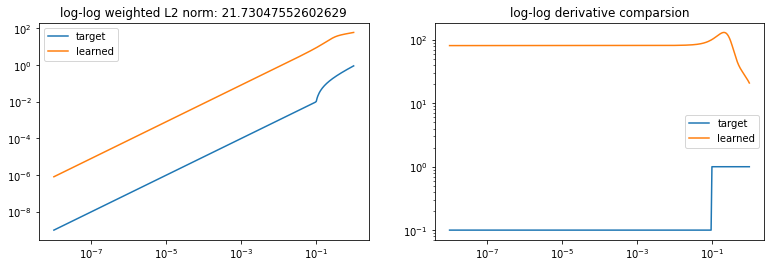

epoch 250


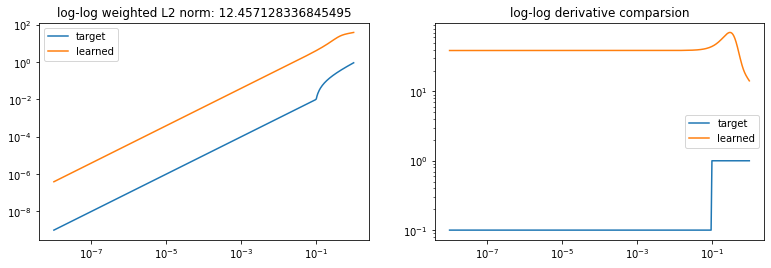

epoch 500


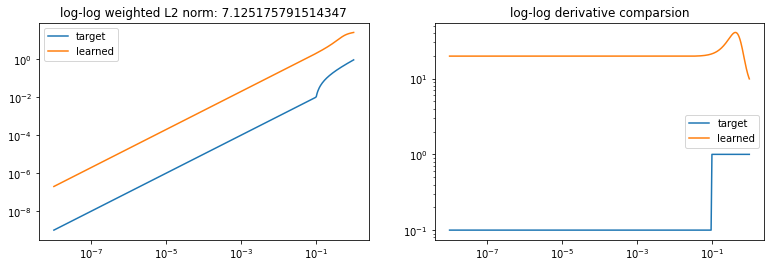

epoch 750


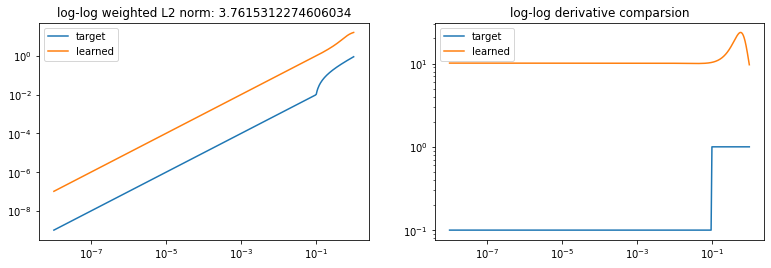

epoch 1000


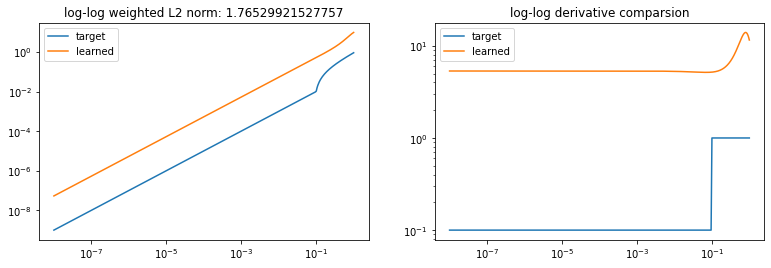

epoch 1250


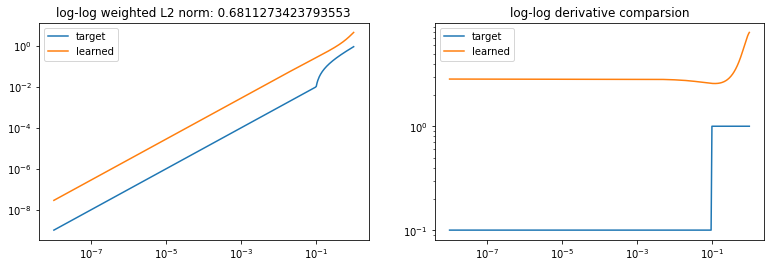

epoch 1500


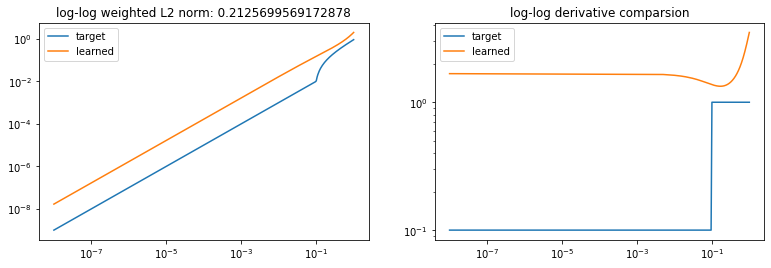

epoch 1750


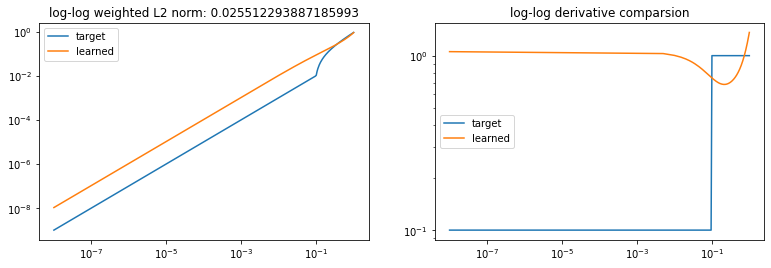

epoch 2000


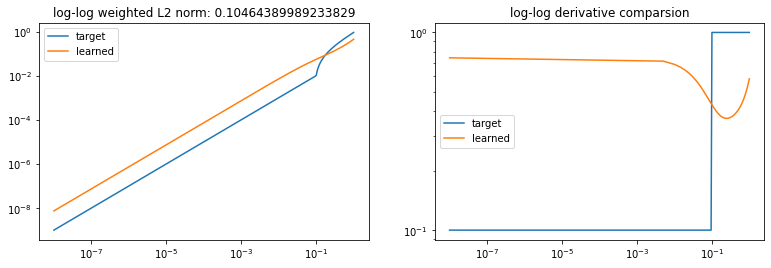

epoch 2250


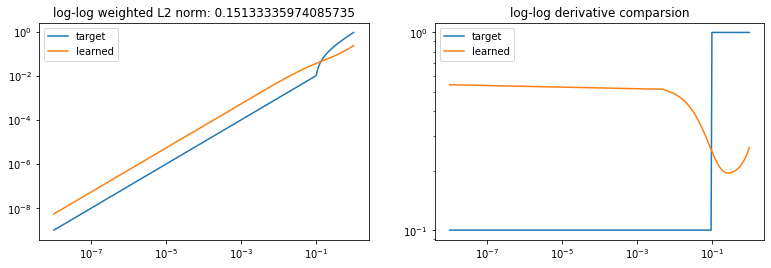

epoch 2500


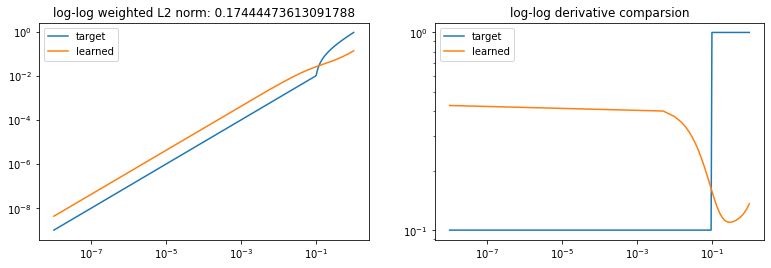

epoch 2750


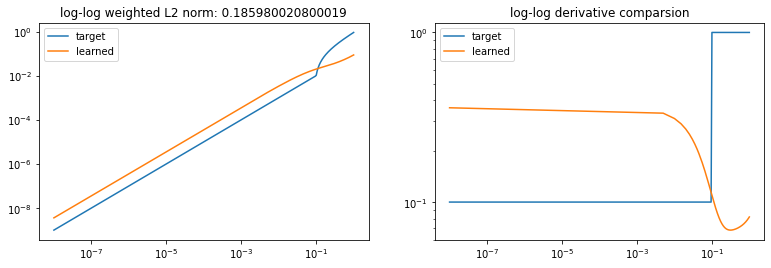

epoch 3000


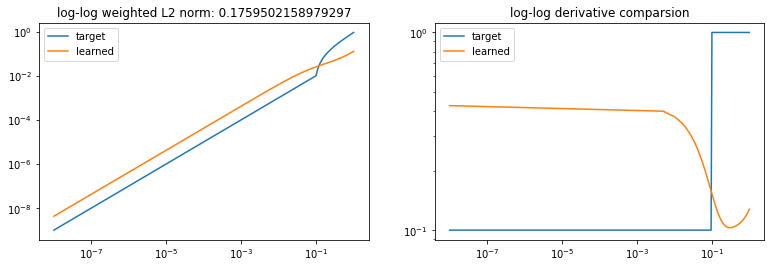

epoch 3250


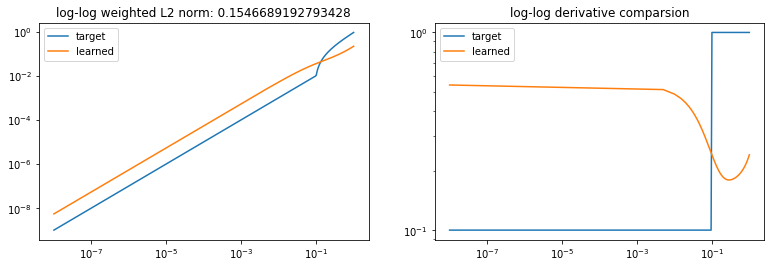

epoch 3500


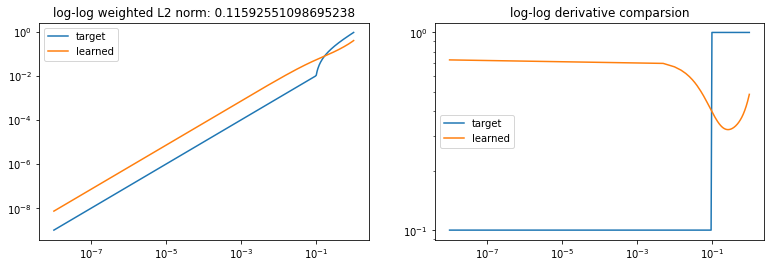

epoch 3750


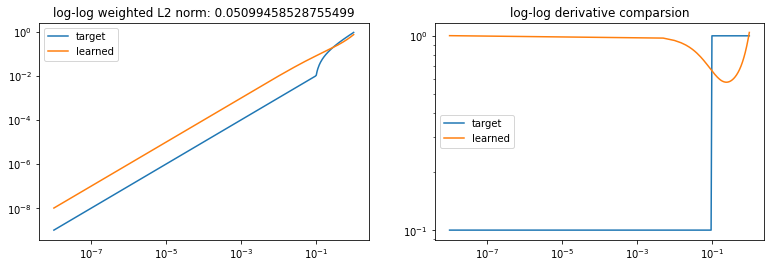

epoch 4000


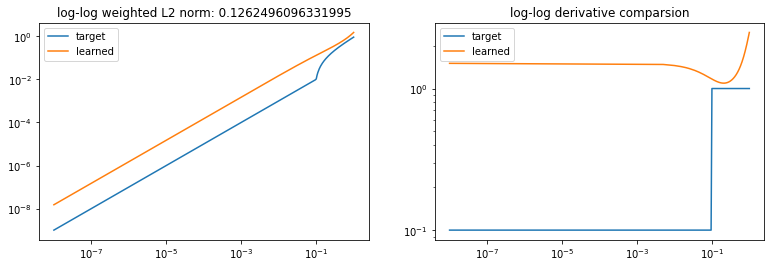

epoch 4250


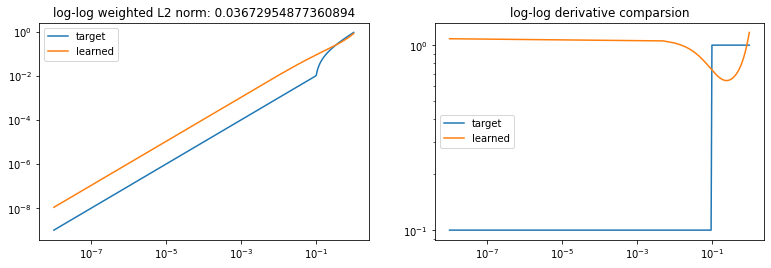

epoch 4500


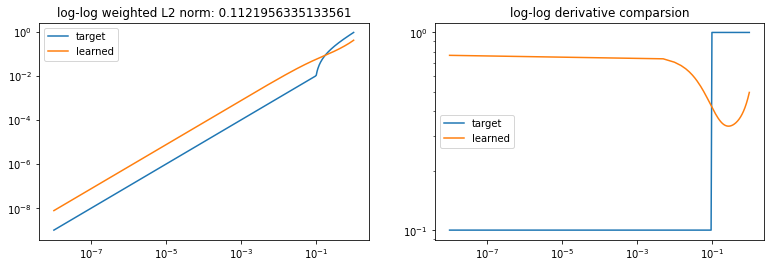

epoch 4750


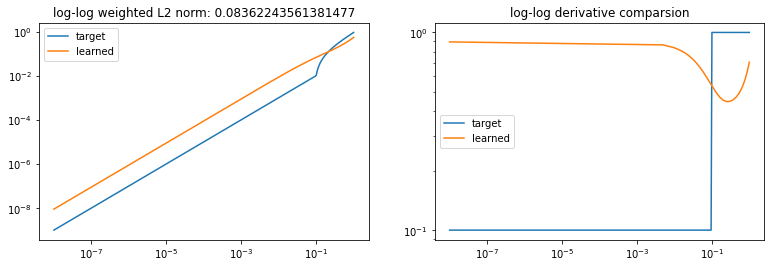

epoch 5000


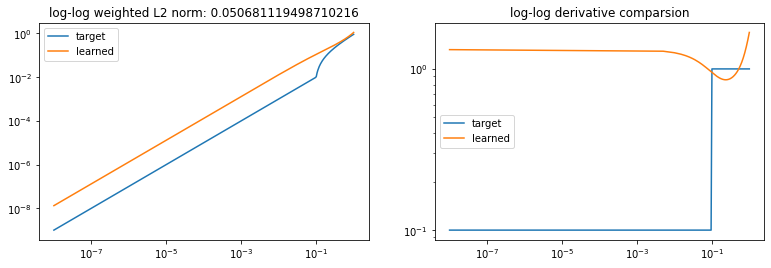

epoch 5250


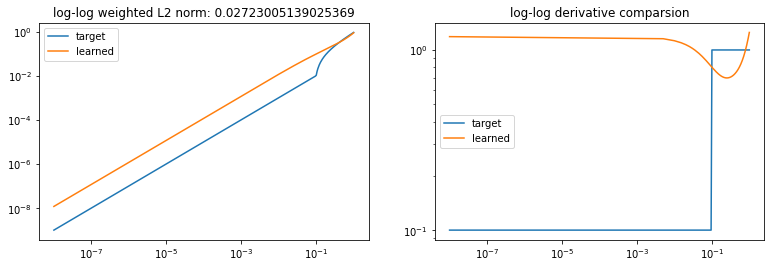

epoch 5500


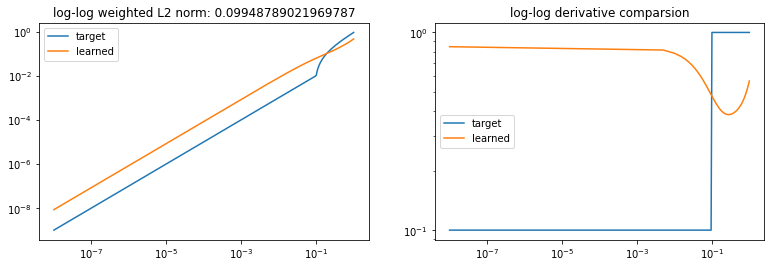

epoch 5750


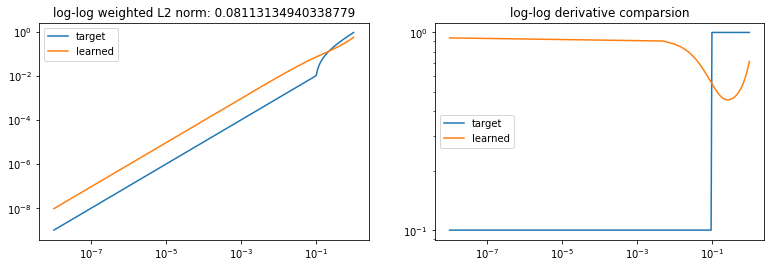

epoch 6000


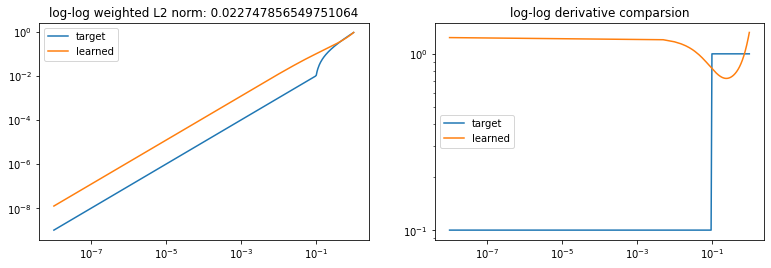

CPU times: user 1h 17min 8s, sys: 1min 18s, total: 1h 18min 27s
Wall time: 1h 12min 58s


In [21]:
%%time
mse = []
training(EPOCHES)

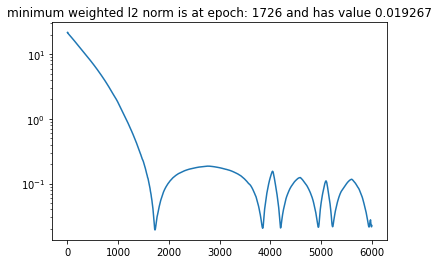

In [27]:
plt.plot(range(len(mse)),mse)
min_mse = min(mse)
min_pos = mse.index(min_mse)
plt.yscale('log')
plt.title(f"minimum weighted l2 norm is at epoch: {min_pos} and has value {min_mse[0]:.6f}")
plt.show()

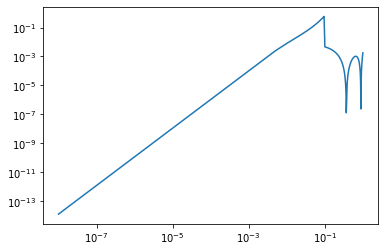

In [29]:
se = np.square([R_learned(R_real_inv(x))[0] - x for x in x_li])
plt.yscale('log')
plt.xscale('log')
plt.plot(x_li, se)
plt.show()